## 1. Cargar librerías y datos

In [167]:
pip install keras_tuner


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: /Users/sporella/Desktop/magister/topicos_ciencia_datos/proyecto1/env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Dropout, Embedding, Flatten, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras_tuner
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc,
    classification_report
)

print("✓ Libraries loaded")

✓ Libraries loaded


In [169]:
# Set the seed for reproducibility
seed_value = 42
keras.utils.set_random_seed(seed_value)

## 2. Cargar dataset procesado

Usamos el dataset ya codificado del notebook `eda.ipynb`.

In [170]:
# Cargar dataset ya procesado
encoded_df = pd.read_csv('dataset/dataset_elpino_codes_encoded.csv')

print(f"Dataset loaded: {encoded_df.shape}")
encoded_df.head()

Dataset loaded: (14561, 86)


,Diag 01 Principal (cod+des),Diag 02 Secundario (cod+des),Diag 03 Secundario (cod+des),Diag 04 Secundario (cod+des),Diag 05 Secundario (cod+des),Diag 06 Secundario (cod+des),Diag 07 Secundario (cod+des),Diag 08 Secundario (cod+des),Diag 09 Secundario (cod+des),Diag 10 Secundario (cod+des),...,Sección,Capítulo,IR-GRD CÓDIGO,NOMBRE DEL GRUPO GRD,Peso v31,CDM_COD,CATEGORÍA DIAGNÓSTICA MAYOR CDM,TIPO_COD,TIPO GRD,Precio FONASA 2016
0,935,997,1827,2626,1028,2422,2366,1029,934,2082,...,A30-A49 OTRAS ENFERMEDADES BACTERIANAS,Cap.01 CIERTAS ENFERMEDADES INFECCIOSAS Y PAR...,184103,MH SEPTICEMIA W/MCC,1.4032,18,ENFERMEDADES INFECCIOSAS Y PARASITARIAS SISTÉM...,MH,MÉDICO HOSPITALIZADO,2.104800e+06
1,3827,2008,3298,3297,3364,4272,4245,2095,2090,2085,...,U00-U49 ASIGNACION PROVISIONAL DE NUEVAS ENFE...,Cap.22 CÓDIGOS PARA SITUACIONES ESPECIALES (U...,41013,PH VENTILACIÓN MECÁNICA PROLONGADA CON TRAQUEO...,11.7045,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,1.893578e+07
2,2223,3374,3373,2073,4243,2012,3833,1025,1034,993,...,K55-K64 OTRAS ENFERMEDADES DE LOS INTESTINOS,Cap.11 ENFERMEDADES DEL APARATO DIGESTIVO (K0...,41013,PH VENTILACIÓN MECÁNICA PROLONGADA CON TRAQUEO...,11.7045,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,1.893578e+07
3,2295,2267,2651,1249,1404,1401,2074,2645,2063,3343,...,K70-K77 ENFERMEDADES DE HÍGADO,Cap.11 ENFERMEDADES DEL APARATO DIGESTIVO (K0...,41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,5.8207,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,9.416848e+06
4,3789,4226,3506,3534,3975,2097,2012,3833,3827,2687,...,T80-T88 COMPLICACIONES DE LA ATENCIÓN QUIRÚRG...,"Cap.19 LESIONES TRAUMÁTICAS, ENVENENAMIENTOS ...",41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,5.8207,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,9.416848e+06


## 3. Filtrar por categoría de interés

Igual que en `eda.ipynb`, filtramos por diagnósticos que empiecen con 'K' (enfermedades digestivas).

In [171]:
# Filter by ICD-10 code starting with 'K'
encoded_df_filter = encoded_df.loc[encoded_df["Código"].str.startswith('K', na=False)]

# Count records by GRD_final
grd_cuenta = encoded_df_filter.groupby("GRD_final").size().sort_values(ascending=False).reset_index(name='Count')

print("\nTop 10 GRDs with most cases:")
print(grd_cuenta.head(10))

# Filter GRDs with at least 5 cases
grd_con_datos = grd_cuenta.GRD_final[grd_cuenta.Count >= 5]
encoded_df_filter_final = encoded_df_filter[encoded_df_filter.GRD_final.isin(grd_con_datos)].copy()

print(f"\nRecords after filtering: {len(encoded_df_filter_final)}")
print(f"Unique GRDs: {encoded_df_filter_final['GRD_final'].nunique()}")


Top 10 GRDs with most cases:
   GRD_final  Count
0       7114    492
1       6113    320
2       6418    213
3       7414    132
4       6112     99
5       7410     87
6       6120     83
7       7413     80
8       7412     80
9       6413     73

Records after filtering: 2010
Unique GRDs: 29


## 4. Visualizar distribución de clases

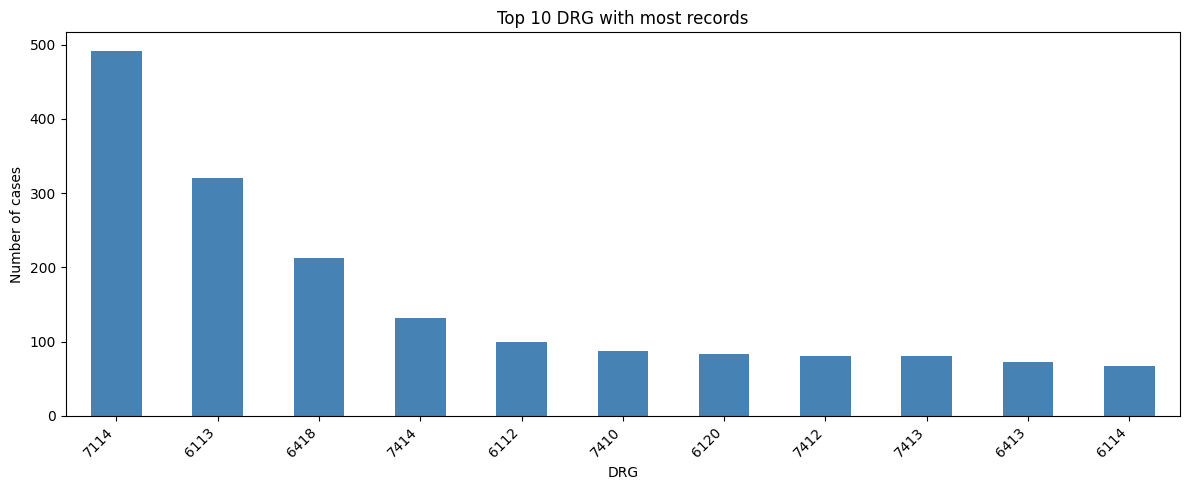


Total de clases: 11


In [172]:
# Visualizar top 10 GRD
top_grds = encoded_df_filter_final['GRD_final'].value_counts().head(11)

plt.figure(figsize=(12, 5))
top_grds.plot(kind='bar', color='steelblue')
plt.title('Top 10 DRG with most records')
plt.xlabel('DRG')
plt.ylabel('Number of cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTotal de clases: {len(top_grds)}")

## 5. Preparar features (X) y target (Y)

Usamos las columnas codificadas de diagnósticos y procedimientos como features.

In [173]:
# Identify feature columns
diag_cols = [c for c in encoded_df_filter_final.columns if c.startswith('Diag')]
proc_cols = [c for c in encoded_df_filter_final.columns if c.startswith('Proced')]

# Usar diagnóstico principal + primeros 5 procedimientos + edad + sexo
#feature_cols = proc_cols[:5] + ['Edad', 'Sexo']
feature_cols = diag_cols[:1] + proc_cols[:5] + ['Edad', 'Sexo']

print(f"Selected features ({len(feature_cols)}):")
print(feature_cols)

# Create X matrix
X = encoded_df_filter_final[feature_cols].fillna(0).to_numpy()

print(f"\nX shape: {X.shape}")
print(f"First 3 records:")
print(X[:3])

Selected features (8):
['Diag 01 Principal (cod+des)', 'Proced 01 Principal (cod+des)', 'Proced 02 Secundario (cod+des)', 'Proced 03 Secundario (cod+des)', 'Proced 04 Secundario (cod+des)', 'Proced 05 Secundario (cod+des)', 'Edad', 'Sexo']

X shape: (2010, 8)
First 3 records:
[[2223  587  339  837   51  177   65    1]
 [2295  332  118  590  341  837   61    1]
 [2344  177  609  644  617  629   61    1]]


### 5.1 Separar features categóricas y numéricas

Para usar embeddings, necesitamos separar:
- **Categóricas**: Diag y Proced (códigos enteros que representan categorías)
- **Numéricas**: Edad y Sexo

In [174]:
# Separate categorical (for embedding) and numerical features
cat_feature_cols = diag_cols[:1] + proc_cols[:5]  # Main diagnosis + 5 procedures
num_feature_cols = ['Edad', 'Sexo']

print(f"Categorical features ({len(cat_feature_cols)}):")
for col in cat_feature_cols:
    print(f"  - {col}")

print(f"\nNumerical features ({len(num_feature_cols)}):")
for col in num_feature_cols:
    print(f"  - {col}")

# Create separate arrays
X_cat = encoded_df_filter_final[cat_feature_cols].fillna(0).astype(int).to_numpy()
X_num = encoded_df_filter_final[num_feature_cols].fillna(0).to_numpy()

# Calculate vocabularies (number of unique categories + 1 for padding)
vocab_sizes = []
for col in cat_feature_cols:
    vocab_size = int(encoded_df_filter_final[col].max()) + 1
    vocab_sizes.append(vocab_size)
    print(f"\n{col}: {vocab_size} unique categories")

print(f"\nX_cat shape: {X_cat.shape}")
print(f"X_num shape: {X_num.shape}")
print(f"\nFirst 3 records (categorical):")
print(X_cat[:3])
print(f"\nFirst 3 records (numerical):")
print(X_num[:3])

Categorical features (6):
  - Diag 01 Principal (cod+des)
  - Proced 01 Principal (cod+des)
  - Proced 02 Secundario (cod+des)
  - Proced 03 Secundario (cod+des)
  - Proced 04 Secundario (cod+des)
  - Proced 05 Secundario (cod+des)

Numerical features (2):
  - Edad
  - Sexo

Diag 01 Principal (cod+des): 2347 unique categories

Proced 01 Principal (cod+des): 901 unique categories

Proced 02 Secundario (cod+des): 901 unique categories

Proced 03 Secundario (cod+des): 901 unique categories

Proced 04 Secundario (cod+des): 903 unique categories

Proced 05 Secundario (cod+des): 901 unique categories

X_cat shape: (2010, 6)
X_num shape: (2010, 2)

First 3 records (categorical):
[[2223  587  339  837   51  177]
 [2295  332  118  590  341  837]
 [2344  177  609  644  617  629]]

First 3 records (numerical):
[[65  1]
 [61  1]
 [61  1]]


## 6. Codificar target (Y) - Enfoque One-Hot

Similar al ejemplo de clase con clasificación multiclase.

In [175]:
# Encode GRD_final as numerical categories
Q = encoded_df_filter_final['GRD_final'].astype('category').cat.codes

print("Class distribution:")
print(Q.value_counts().sort_index())

# One-Hot encoding for Keras (multiclass classification)
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Q.to_numpy().reshape(-1, 1))

print(f"\nY shape: {Y.shape}")
print(f"Number of classes: {Y.shape[1]}")
print(f"\nFirst 3 records (one-hot):")
print(Y[:3])

Class distribution:
0       5
1      39
2      23
3       8
4      14
5      99
6     320
7      67
8      83
9       5
10     14
11     53
12     15
13     27
14     73
15      9
16     21
17     12
18     12
19    213
20      5
21      7
22      7
23      8
24    492
25     87
26     80
27     80
28    132
Name: count, dtype: int64

Y shape: (2010, 29)
Number of classes: 29

First 3 records (one-hot):
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 7. Mapeo de códigos a nombres de GRD

In [176]:
# Create mapping from numerical index to GRD code
label_encoder = LabelEncoder()
label_encoder.fit(encoded_df_filter_final['GRD_final'])

grd_labels = label_encoder.classes_

print(f"Class mapping (first 10):")
for idx, grd in enumerate(grd_labels[:10]):
    print(f"  {idx} -> {grd}")

Class mapping (first 10):
  0 -> 4101
  1 -> 4102
  2 -> 4120
  3 -> 6110
  4 -> 6111
  5 -> 6112
  6 -> 6113
  7 -> 6114
  8 -> 6120
  9 -> 6130


## 8. Split train/test con estratificación

In [177]:
# Split 80/20 with stratification for both feature types
x_cat_train, x_cat_test, x_num_train, x_num_test, y_train, y_test = train_test_split(
    X_cat, X_num, Y,
    test_size=0.2,
    stratify=Y,  # Maintain class proportion
    random_state=42
)

print(f"Train set (cat): {x_cat_train.shape}")
print(f"Train set (num): {x_num_train.shape}")
print(f"Test set (cat): {x_cat_test.shape}")
print(f"Test set (num): {x_num_test.shape}")

Train set (cat): (1608, 6)
Train set (num): (1608, 2)
Test set (cat): (402, 6)
Test set (num): (402, 2)


## 9. Visualizar desbalanceo de clases

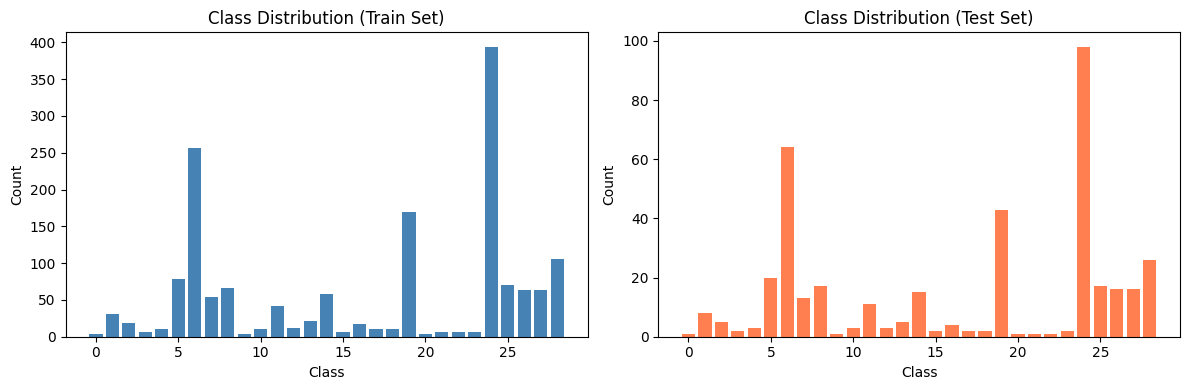


Classes with less than 10 records in train: 8


In [178]:
# Count classes in train and test sets
train_classes = np.argmax(y_train, axis=1)
test_classes = np.argmax(y_test, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train set class distribution
class_counts_train = pd.Series(train_classes).value_counts().sort_index()
axes[0].bar(class_counts_train.index, class_counts_train.values, color='steelblue')
axes[0].set_title('Class Distribution (Train Set)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Test set class distribution
class_counts_test = pd.Series(test_classes).value_counts().sort_index()
axes[1].bar(class_counts_test.index, class_counts_test.values, color='coral')
axes[1].set_title('Class Distribution (Test Set)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f"\nClasses with less than 10 records in train: {(class_counts_train < 10).sum()}")

## 10. Balanceo de clases: comparación de técnicas

Comparamos tres enfoques:
1. **RandomOverSampler (ROS)**: Duplica muestras de clases minoritarias
2. **RandomUnderSampler (RUS)**: Reduce muestras de clases mayoritarias
3. **Sin balanceo**: Datos originales

Train original:    (1608, 8)
Train ROS:         (11426, 8)
Train RUS:         (116, 8)


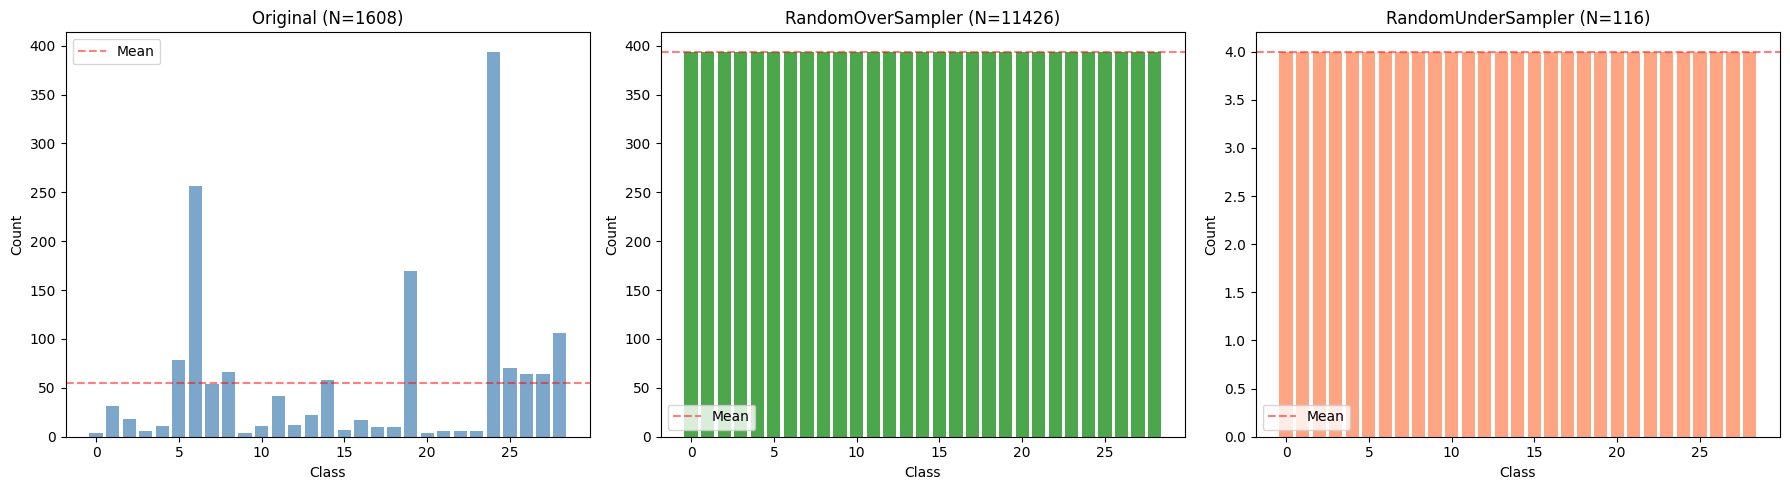


📊 Analysis of balancing:
  Original - Std: 85.85, Min: 4, Max: 394
  ROS      - Std: 0.00, Min: 394, Max: 394
  RUS      - Std: 0.00, Min: 4, Max: 4


In [179]:
# Concatenate categorical and numerical features for balancing
x_train_combined = np.concatenate([x_cat_train, x_num_train], axis=1)
x_test_combined = np.concatenate([x_cat_test, x_num_test], axis=1)

# Apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train_ros_combined, y_train_ros = ros.fit_resample(x_train_combined, y_train)

# Apply RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
x_train_rus_combined, y_train_rus = rus.fit_resample(x_train_combined, y_train)

# Separate again after balancing
n_cat = x_cat_train.shape[1]
x_cat_train_ros = x_train_ros_combined[:, :n_cat]
x_num_train_ros = x_train_ros_combined[:, n_cat:]

x_cat_train_rus = x_train_rus_combined[:, :n_cat]
x_num_train_rus = x_train_rus_combined[:, n_cat:]

print(f"Train original:    {x_train_combined.shape}")
print(f"Train ROS:         {x_train_ros_combined.shape}")
print(f"Train RUS:         {x_train_rus_combined.shape}")

# Visualize after balancing
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original
train_classes = np.argmax(y_train, axis=1)
class_counts_original = pd.Series(train_classes).value_counts().sort_index()
axes[0].bar(class_counts_original.index, class_counts_original.values, color='steelblue', alpha=0.7)
axes[0].set_title(f'Original (N={len(train_classes)})')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].axhline(y=class_counts_original.mean(), color='r', linestyle='--', alpha=0.5, label='Mean')
axes[0].legend()

# RandomOverSampler
train_ros_classes = np.argmax(y_train_ros, axis=1)
class_counts_ros = pd.Series(train_ros_classes).value_counts().sort_index()
axes[1].bar(class_counts_ros.index, class_counts_ros.values, color='green', alpha=0.7)
axes[1].set_title(f'RandomOverSampler (N={len(train_ros_classes)})')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].axhline(y=class_counts_ros.mean(), color='r', linestyle='--', alpha=0.5, label='Mean')
axes[1].legend()

# RandomUnderSampler
train_rus_classes = np.argmax(y_train_rus, axis=1)
class_counts_rus = pd.Series(train_rus_classes).value_counts().sort_index()
axes[2].bar(class_counts_rus.index, class_counts_rus.values, color='coral', alpha=0.7)
axes[2].set_title(f'RandomUnderSampler (N={len(train_rus_classes)})')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')
axes[2].axhline(y=class_counts_rus.mean(), color='r', linestyle='--', alpha=0.5, label='Mean')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Analysis of balancing:")
print(f"  Original - Std: {class_counts_original.std():.2f}, Min: {class_counts_original.min()}, Max: {class_counts_original.max()}")
print(f"  ROS      - Std: {class_counts_ros.std():.2f}, Min: {class_counts_ros.min()}, Max: {class_counts_ros.max()}")
print(f"  RUS      - Std: {class_counts_rus.std():.2f}, Min: {class_counts_rus.min()}, Max: {class_counts_rus.max()}")

### 10.1 Selección de estrategia de balanceo

**Trade-offs:**
- **ROS**: Aumenta tamaño del dataset, puede causar overfitting (duplica ejemplos)
- **RUS**: Reduce tamaño del dataset, pierde información pero evita overfitting
- **Sin balanceo**: Mantiene distribución real pero puede sesgar hacia clases mayoritarias

Para este análisis usaremos **RandomOverSampler (ROS)** para mantener toda la información disponible.

## 11. Definir función para crear modelo con Keras Tuner

Siguiendo el patrón de la clase, creamos una función que Keras Tuner pueda optimizar.

In [180]:
def build_model(hp):
    """
    Function to create a model with embeddings for categorical features.

    Architecture:
    - Embeddings for each categorical feature (Diag + Proced)
    - Concatenation with numerical features
    - Dense layers with dropout
    - Softmax for multiclass classification

    Hyperparameters to optimize:
    - Embedding dimension: 8, 16, 32
    - Number of hidden layers: 1, 2 or 3
    - Neurons per layer: 64, 128, 256, 512
    - Dropout: 0.2, 0.3, 0.4
    - Learning rate: 0.001, 0.0001
    """

    # Embedding dimension (same for all categorical features)
    embedding_dim = hp.Choice("embedding_dim", [8, 16, 32])

    # Inputs: one input for each categorical feature + one for numerical
    cat_inputs = []
    embeddings = []

    # Create embedding for each categorical feature
    for i, vocab_size in enumerate(vocab_sizes):
        input_cat = Input(shape=(1,), name=f'cat_input_{i}')
        cat_inputs.append(input_cat)

        # Embedding layer
        emb = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name=f'embedding_{i}'
        )(input_cat)
        emb = Flatten()(emb)
        embeddings.append(emb)

    # Input for numerical features
    num_input = Input(shape=(x_num_train_ros.shape[1],), name='num_input')

    # Concatenate all embeddings + numerical features
    if embeddings:
        concat = Concatenate()(embeddings + [num_input])
    else:
        concat = num_input

    # Dense layers
    x = concat
    for i in range(hp.Choice("num_capas", [1, 2, 3])):
        x = Dense(
            hp.Choice(f"neuronas_capa_{i}", [64, 128, 256, 512]),
            activation='relu',
            name=f'dense_{i}'
        )(x)
        x = Dropout(hp.Choice("dropout", [0.2, 0.3, 0.4]))(x)

    # Output layer
    output = Dense(Y.shape[1], activation='softmax', name='output')(x)

    # Create model
    model = Model(inputs=cat_inputs + [num_input], outputs=output)

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("lr", [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
    )

    return model

print("✓ build_model function with embeddings defined")

✓ build_model function with embeddings defined


## 12. Configurar Keras Tuner (RandomSearch)

In [181]:
# Configure tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_acc", direction="max"),
    max_trials=20,  # Number of combinations to try
    executions_per_trial=2,  # Train each config 2 times
    overwrite=True,
    directory="modelos_keras",
    project_name="grd_clasificacion"
)

print("✓ Keras Tuner configured")
tuner.search_space_summary()

✓ Keras Tuner configured
Search space summary
Default search space size: 5
embedding_dim (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
num_capas (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
neuronas_capa_0 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
lr (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


## 13. Ejecutar búsqueda de hiperparámetros

**Nota:** Esto puede tomar varios minutos dependiendo de `max_trials`. (14 min aprox con la configuración actual)

In [182]:
# Search for best hyperparameters using ROS balanced data
# Prepare inputs for the model: list of arrays, one for each categorical feature + numerical
x_train_inputs = [x_cat_train_ros[:, i:i+1] for i in range(x_cat_train_ros.shape[1])] + [x_num_train_ros]
x_test_inputs = [x_cat_test[:, i:i+1] for i in range(x_cat_test.shape[1])] + [x_num_test]

# Simple callback to show progress each epoch
class SimpleProgressCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_count = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if logs:
            print(f"Epoch {epoch+1}/15 - loss: {logs.get('loss', 0):.4f} - acc: {logs.get('acc', 0):.4f} - val_loss: {logs.get('val_loss', 0):.4f} - val_acc: {logs.get('val_acc', 0):.4f}")

# Search with simple callback
tuner.search(
    x_train_inputs,
    y_train_ros,
    validation_data=(x_test_inputs, y_test),
    epochs=15,
    batch_size=32,
    verbose=0,
    callbacks=[SimpleProgressCallback()]
)

print(f"\n✓ Search completed - Total trials: {len(tuner.oracle.trials)}")

Epoch 1/15 - loss: 3.4914 - acc: 0.0475 - val_loss: 3.3483 - val_acc: 0.1642
Epoch 2/15 - loss: 3.0943 - acc: 0.1097 - val_loss: 3.0561 - val_acc: 0.0920
Epoch 3/15 - loss: 1.8876 - acc: 0.3843 - val_loss: 1.3580 - val_acc: 0.6940
Epoch 4/15 - loss: 0.8400 - acc: 0.7151 - val_loss: 0.8827 - val_acc: 0.7960
Epoch 5/15 - loss: 0.4332 - acc: 0.8538 - val_loss: 0.7860 - val_acc: 0.8781
Epoch 6/15 - loss: 0.2629 - acc: 0.9136 - val_loss: 0.8053 - val_acc: 0.8806
Epoch 7/15 - loss: 0.2002 - acc: 0.9376 - val_loss: 0.8281 - val_acc: 0.8881
Epoch 8/15 - loss: 0.1467 - acc: 0.9546 - val_loss: 0.8861 - val_acc: 0.8806
Epoch 9/15 - loss: 0.1239 - acc: 0.9625 - val_loss: 0.9197 - val_acc: 0.9030
Epoch 10/15 - loss: 0.0943 - acc: 0.9703 - val_loss: 0.9430 - val_acc: 0.9104
Epoch 11/15 - loss: 0.0867 - acc: 0.9730 - val_loss: 1.0113 - val_acc: 0.9005
Epoch 12/15 - loss: 0.0806 - acc: 0.9759 - val_loss: 0.9860 - val_acc: 0.9080
Epoch 13/15 - loss: 0.0749 - acc: 0.9777 - val_loss: 1.0340 - val_acc: 0.

## 14. Obtener mejor modelo

In [183]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(f"  Embedding dimension: {best_hps.get('embedding_dim')}")
print(f"  Number of layers: {best_hps.get('num_capas')}")
print(f"  Dropout: {best_hps.get('dropout')}")
print(f"  Learning rate: {best_hps.get('lr')}")
for i in range(best_hps.get('num_capas')):
    print(f"  Neurons layer {i}: {best_hps.get(f'neuronas_capa_{i}')}")

# Get best model
mejor_modelo = tuner.get_best_models(num_models=1)[0]
mejor_modelo.summary()

Best hyperparameters:
  Embedding dimension: 16
  Number of layers: 2
  Dropout: 0.4
  Learning rate: 0.001
  Neurons layer 0: 128
  Neurons layer 1: 512
Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cat_input_0 (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_input_1 (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_input_2 (InputLayer)      │ (None, 1)                 │  

/Users/sporella/Desktop/magister/topicos_ciencia_datos/proyecto1/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 15. Guardar mejor modelo

In [184]:
# Save model
import os

if not os.path.exists("models"):
    os.makedirs("models")

mejor_modelo.save('models/mejor_modelo_grd.keras')
print("✓ Model saved to: models/mejor_modelo_grd.keras")

✓ Model saved to: models/mejor_modelo_grd.keras


## 16. Evaluar en conjunto de test

In [185]:
# Predict probabilities with correct inputs
y_pred_probs = mejor_modelo.predict(x_test_inputs)

# Convert probabilities to classes
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Metrics on test set:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {precision:.4f} (macro)")
print(f"  Recall:    {recall:.4f} (macro)")
print(f"  F1-Score:  {f1:.4f} (macro)")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Metrics on test set:
  Accuracy:  0.9229
  Precision: 0.7994 (macro)
  Recall:    0.7313 (macro)
  F1-Score:  0.7381 (macro)


## 17. Matriz de Confusión

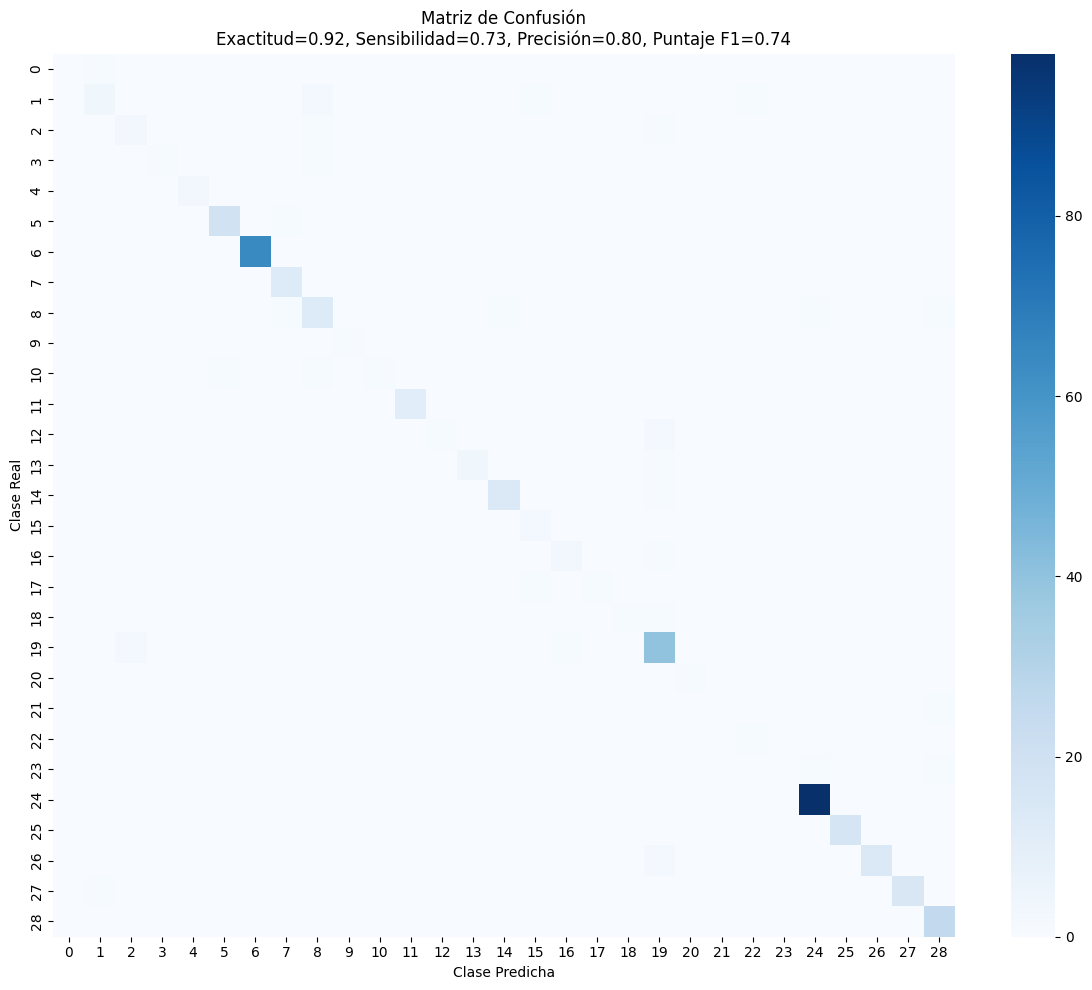

Matriz shape: (29, 29)


In [186]:
# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar (puede ser grande si hay muchas clases)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True, fmt='d')
plt.title(f'Matriz de Confusión\nExactitud={acc:.2f}, Sensibilidad={recall:.2f}, Precisión={precision:.2f}, Puntaje F1={f1:.2f}')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.tight_layout()
plt.savefig('models/confusion_matrix_grd.png', dpi=150)
plt.show()

print(f"Matriz shape: {cm.shape}")

## 18. Reporte de clasificación por clase

In [187]:
# Detailed report by class
report = classification_report(
    y_true,
    y_pred,
    target_names=[str(g) for g in grd_labels],
    zero_division=0
)

print("Classification report by GRD:")
print(report)

Classification report by GRD:
              precision    recall  f1-score   support

        4101       0.00      0.00      0.00         1
        4102       0.67      0.50      0.57         8
        4120       0.60      0.60      0.60         5
        6110       1.00      0.50      0.67         2
        6111       1.00      1.00      1.00         3
        6112       0.95      0.95      0.95        20
        6113       1.00      1.00      1.00        64
        6114       0.87      1.00      0.93        13
        6120       0.72      0.76      0.74        17
        6130       1.00      1.00      1.00         1
        6140       1.00      0.33      0.50         3
        6150       1.00      1.00      1.00        11
        6411       1.00      0.33      0.50         3
        6412       1.00      0.80      0.89         5
        6413       0.93      0.93      0.93        15
        6414       0.50      1.00      0.67         2
        6415       0.75      0.75      0.75        

## 19. Curvas ROC (One-vs-Rest)

Visualizamos curvas ROC para las clases principales.

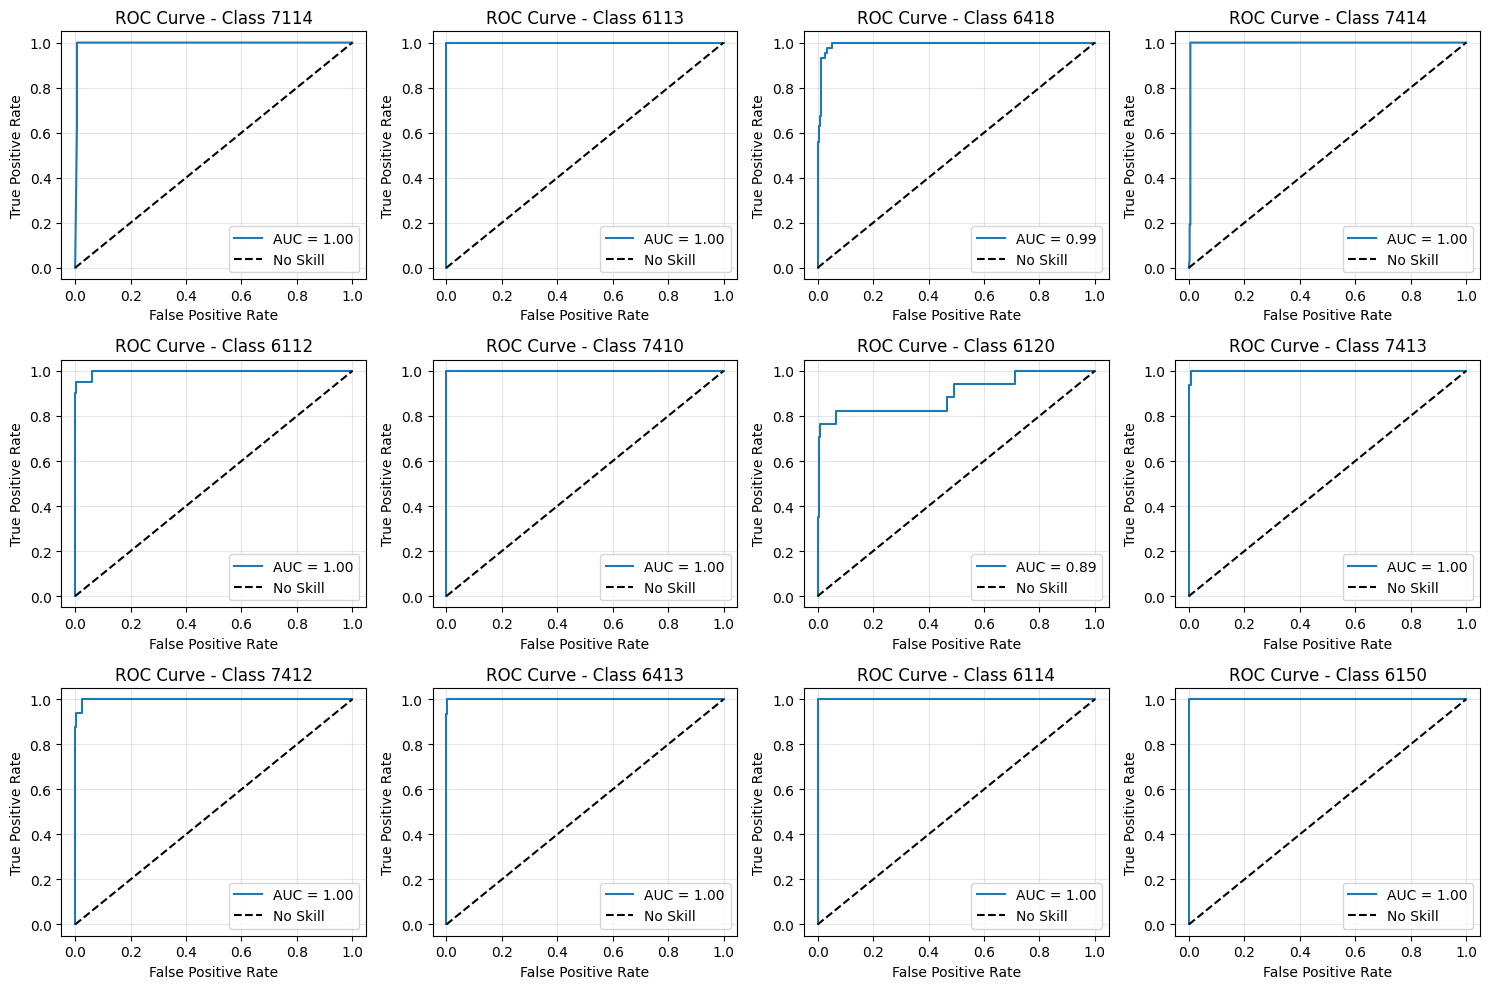

In [188]:
# Select top 12 most frequent classes to visualize ROC
top_classes = pd.Series(y_true).value_counts().head(12).index.tolist()

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for idx, cls in enumerate(top_classes):
    # ROC for this class (one-vs-rest)
    fpr, tpr, _ = roc_curve(y_test[:, cls], y_pred_probs[:, cls])
    roc_auc = auc(fpr, tpr)

    axes[idx].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axes[idx].plot([0, 1], [0, 1], 'k--', label='No Skill')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'ROC Curve - Class {grd_labels[cls]}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/roc_curves_grd.png', dpi=150)
plt.show()

## 20. Análisis de errores - Top confusiones


Top 15 most frequent confusions:
 True  Predicted  Count
 6411       6418      2
 7412       6418      2
 6418       4120      2
 4102       6120      2
 4101       4102      1
 7113       7414      1
 7113       7114      1
 7111       7414      1
 6418       6415      1
 6417       6418      1
 6416       6414      1
 6415       6418      1
 6413       6418      1
 6412       6418      1
 6140       6120      1


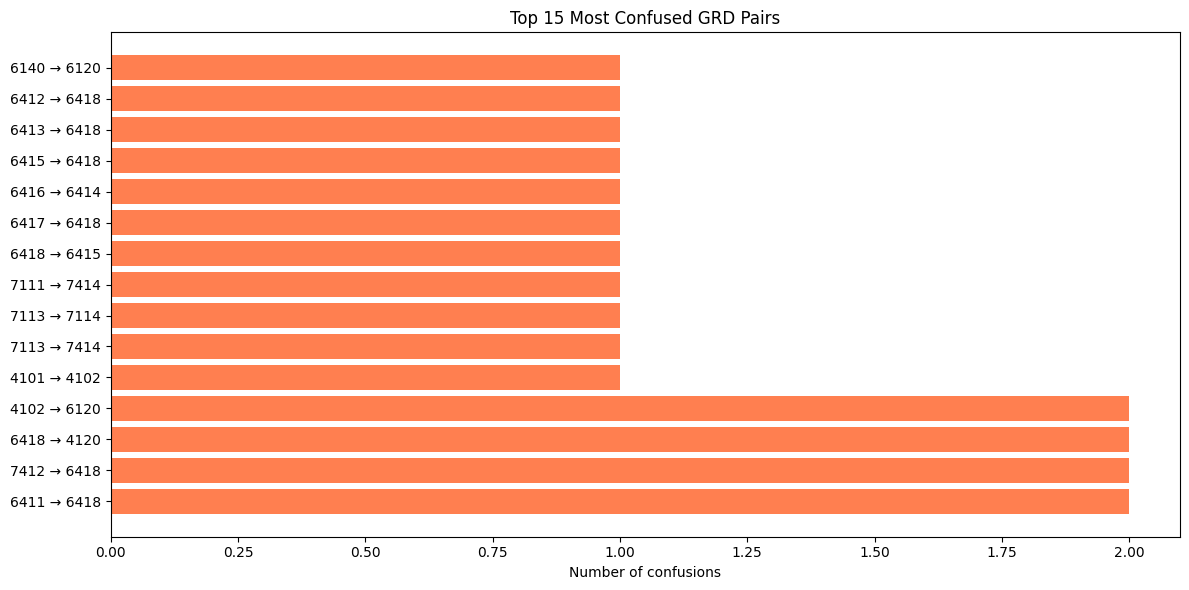

In [189]:
# Find top confusions (off-diagonal)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)  # Remove diagonal

# Top 10 most confused pairs
top_confusions = []
for i in range(cm_copy.shape[0]):
    for j in range(cm_copy.shape[1]):
        if cm_copy[i, j] > 0:
            top_confusions.append({
                'True': grd_labels[i],
                'Predicted': grd_labels[j],
                'Count': cm_copy[i, j]
            })

top_confusions_df = pd.DataFrame(top_confusions).sort_values('Count', ascending=False).head(15)

print("\nTop 15 most frequent confusions:")
print(top_confusions_df.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(
    range(len(top_confusions_df)),
    top_confusions_df['Count'],
    color='coral'
)
plt.yticks(
    range(len(top_confusions_df)),
    [f"{row['True']} → {row['Predicted']}" for _, row in top_confusions_df.iterrows()]
)
plt.xlabel('Number of confusions')
plt.title('Top 15 Most Confused GRD Pairs')
plt.tight_layout()
plt.savefig('models/top_confusions_grd.png', dpi=150)
plt.show()

## 21. Comparación ROS vs RUS: Entrenar modelos separados

Vamos a entrenar dos modelos con los mismos hiperparámetros óptimos encontrados:
1. Modelo con **RandomOverSampler (ROS)**
2. Modelo con **RandomUnderSampler (RUS)**

Y comparar:
- Accuracy, Precision, Recall, F1
- Tiempo de entrenamiento
- Matriz de confusión
- Curvas de aprendizaje

In [190]:
import time

# Prepare test data in input format
x_test_inputs = [x_cat_test[:, i:i+1] for i in range(x_cat_test.shape[1])] + [x_num_test]

# Function to train and evaluate a model
def entrenar_y_evaluar(x_train_cat, x_train_num, y_train_data, nombre_estrategia, epochs=20):
    """
    Trains a model with the best hyperparameters and evaluates it on the test set.
    """
    print(f"\n{'='*60}")
    print(f"🔥 Training model with {nombre_estrategia}")
    print(f"{'='*60}")

    # Prepare inputs
    x_train_inputs = [x_train_cat[:, i:i+1] for i in range(x_train_cat.shape[1])] + [x_train_num]

    # Build model with best hyperparameters
    model = build_model(best_hps)

    # Train
    inicio = time.time()
    history = model.fit(
        x_train_inputs,
        y_train_data,
        validation_data=(x_test_inputs, y_test),
        epochs=epochs,
        batch_size=32,
        verbose=0
    )
    tiempo_entrenamiento = time.time() - inicio

    # Predict
    y_pred_probs = model.predict(x_test_inputs, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📊 Test Set Results:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f} (macro)")
    print(f"  Recall:    {recall:.4f} (macro)")
    print(f"  F1-Score:  {f1:.4f} (macro)")
    print(f"  ⏱️  Time:   {tiempo_entrenamiento:.2f}s")
    print(f"  📦 Train Size: {len(y_train_data)}")

    return {
        'model': model,
        'history': history,
        'metrics': {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tiempo': tiempo_entrenamiento,
            'train_size': len(y_train_data)
        },
        'predictions': {
            'y_true': y_true,
            'y_pred': y_pred,
            'y_pred_probs': y_pred_probs
        },
        'cm': cm
    }

print("✓ Training function defined")

✓ Training function defined


### 21.1 Entrenar modelo con RandomOverSampler (ROS)

In [191]:
# Entrenar con ROS
resultados_ros = entrenar_y_evaluar(
    x_cat_train_ros,
    x_num_train_ros,
    y_train_ros,
    "RandomOverSampler (ROS)",
    epochs=20
)


🔥 Training model with RandomOverSampler (ROS)

📊 Test Set Results:
  Accuracy:  0.9279
  Precision: 0.8069 (macro)
  Recall:    0.7386 (macro)
  F1-Score:  0.7525 (macro)
  ⏱️  Time:   9.09s
  📦 Train Size: 11426


### 21.2 Entrenar modelo con RandomUnderSampler (RUS)

In [192]:
# Entrenar con RUS
resultados_rus = entrenar_y_evaluar(
    x_cat_train_rus,
    x_num_train_rus,
    y_train_rus,
    "RandomUnderSampler (RUS)",
    epochs=20
)


🔥 Training model with RandomUnderSampler (RUS)

📊 Test Set Results:
  Accuracy:  0.0348
  Precision: 0.0190 (macro)
  Recall:    0.0517 (macro)
  F1-Score:  0.0205 (macro)
  ⏱️  Time:   1.99s
  📦 Train Size: 116


### 21.3 Entrenar modelo Sin Balanceo (Baseline)

In [193]:
# Entrenar sin balanceo (datos originales)
resultados_original = entrenar_y_evaluar(
    x_cat_train,
    x_num_train,
    y_train,
    "Sin Balanceo (Baseline)",
    epochs=20
)


🔥 Training model with Sin Balanceo (Baseline)

📊 Test Set Results:
  Accuracy:  0.8582
  Precision: 0.4208 (macro)
  Recall:    0.4333 (macro)
  F1-Score:  0.4207 (macro)
  ⏱️  Time:   2.92s
  📦 Train Size: 1608


### 21.4 Tabla comparativa de métricas

In [194]:
resultados_original

{'model': <Functional name=functional_3, built=True>,
 'history': <keras.src.callbacks.history.History at 0x37f19fb60>,
 'metrics': {'accuracy': 0.8582089552238806,
  'precision': 0.420839145232755,
  'recall': 0.4333479027851404,
  'f1': 0.4206633517402137,
  'tiempo': 2.920478105545044,
  'train_size': 1608},
 'predictions': {'y_true': array([ 6, 25, 25, 19, 11, 19, 19,  7, 24, 13,  7, 19,  6, 24, 24,  6, 24, 19, 13, 24,  8, 10, 25,  5, 24, 24, 22, 14, 14, 27,  6, 19,  7,  5, 24, 24, 19, 27,  6, 24, 28,  5, 19, 26, 24, 24, 28, 19, 19, 25, 25,  5, 24, 24,  7, 24,
          6,  8, 13, 25, 24,  8, 14,  8,  6,  2, 25,  7, 27, 11, 27, 27, 28,  1, 24, 27, 24, 19, 19, 12, 24, 27, 25, 24,  2,  8, 24, 14,  6,  6,  6, 24,  6, 24, 28, 28, 24,  6, 24, 23, 24,  7, 25,  8, 26, 24, 24, 19,  0, 25,  6, 24,
          6, 19, 26, 24,  2,  6,  6, 19, 24,  6,  6, 11,  6, 24, 28,  6,  6, 24, 24, 24, 25, 27,  1, 11, 10, 15, 25, 28, 11, 24, 24, 16, 28, 24,  6, 26, 19, 14,  5,  4, 11, 24, 25,  6,  6,  6, 19,

In [195]:
# Create comparative table
comparacion_df = pd.DataFrame({
    'Strategy': ['No Balancing', 'RandomOverSampler (ROS)', 'RandomUnderSampler (RUS)'],
    'Train Size': [
        resultados_original['metrics']['train_size'],
        resultados_ros['metrics']['train_size'],
        resultados_rus['metrics']['train_size']
    ],
    'Accuracy': [
        resultados_original['metrics']['accuracy'],
        resultados_ros['metrics']['accuracy'],
        resultados_rus['metrics']['accuracy']
    ],
    'Precision (macro)': [
        resultados_original['metrics']['precision'],
        resultados_ros['metrics']['precision'],
        resultados_rus['metrics']['precision']
    ],
    'Recall (macro)': [
        resultados_original['metrics']['recall'],
        resultados_ros['metrics']['recall'],
        resultados_rus['metrics']['recall']
    ],
    'F1-Score (macro)': [
        resultados_original['metrics']['f1'],
        resultados_ros['metrics']['f1'],
        resultados_rus['metrics']['f1']
    ],
    'Time (s)': [
        resultados_original['metrics']['tiempo'],
        resultados_ros['metrics']['tiempo'],
        resultados_rus['metrics']['tiempo']
    ]
})

print("\n" + "="*80)
print("📊 COMPARISON OF BALANCING STRATEGIES")
print("="*80)
print(comparacion_df.to_string(index=False))
print("="*80)

# Highlight best result by metric
print("\n🏆 Best results:")
print(f"  Accuracy:  {comparacion_df.loc[comparacion_df['Accuracy'].idxmax(), 'Strategy']} ({comparacion_df['Accuracy'].max():.4f})")
print(f"  Precision: {comparacion_df.loc[comparacion_df['Precision (macro)'].idxmax(), 'Strategy']} ({comparacion_df['Precision (macro)'].max():.4f})")
print(f"  Recall:    {comparacion_df.loc[comparacion_df['Recall (macro)'].idxmax(), 'Strategy']} ({comparacion_df['Recall (macro)'].max():.4f})")
print(f"  F1-Score:  {comparacion_df.loc[comparacion_df['F1-Score (macro)'].idxmax(), 'Strategy']} ({comparacion_df['F1-Score (macro)'].max():.4f})")
print(f"  Speed: {comparacion_df.loc[comparacion_df['Time (s)'].idxmin(), 'Strategy']} ({comparacion_df['Time (s)'].min():.2f}s)")

# Save table
comparacion_df.to_csv('models/comparacion_balanceo.csv', index=False)
print("\n✓ Table saved to: models/comparacion_balanceo.csv")


📊 COMPARISON OF BALANCING STRATEGIES
                Strategy  Train Size  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)  Time (s)
            No Balancing        1608  0.858209           0.420839        0.433348          0.420663  2.920478
 RandomOverSampler (ROS)       11426  0.927861           0.806944        0.738642          0.752499  9.089601
RandomUnderSampler (RUS)         116  0.034826           0.018959        0.051724          0.020513  1.992123

🏆 Best results:
  Accuracy:  RandomOverSampler (ROS) (0.9279)
  Precision: RandomOverSampler (ROS) (0.8069)
  Recall:    RandomOverSampler (ROS) (0.7386)
  F1-Score:  RandomOverSampler (ROS) (0.7525)
  Speed: RandomUnderSampler (RUS) (1.99s)

✓ Table saved to: models/comparacion_balanceo.csv


### 21.5 Visualización comparativa de métricas

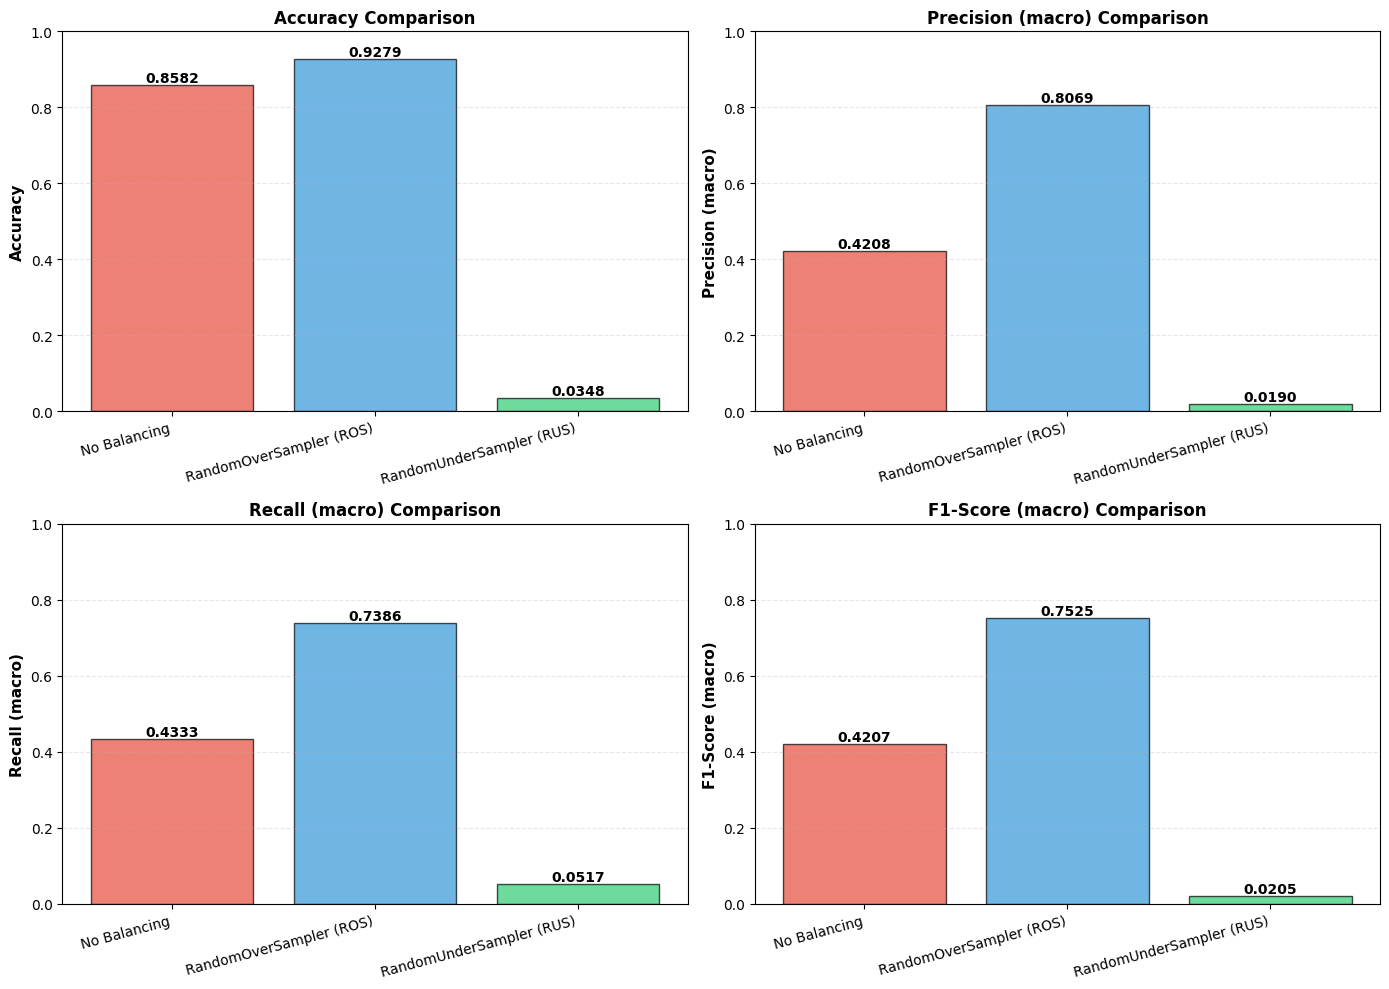

✓ Graph saved in: models/comparacion_metricas_balanceo.png


In [196]:
# Comparative Bar Chart
# Reload comparacion_df as it might have been overwritten by other cells
comparacion_df = pd.read_csv('models/comparacion_balanceo.csv')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)']
colors = ['#e74c3c', '#3498db', '#2ecc71']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2

    ax = axes[row, col]
    x_pos = np.arange(len(comparacion_df))

    bars = ax.bar(x_pos, comparacion_df[metric], color=colors, alpha=0.7, edgecolor='black')

    # Add values on the bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparacion_df['Strategy'], rotation=15, ha='right') # Changed to 'Strategy'
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('models/comparacion_metricas_balanceo.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graph saved in: models/comparacion_metricas_balanceo.png")

### 21.6 Curvas de aprendizaje (Loss y Accuracy)

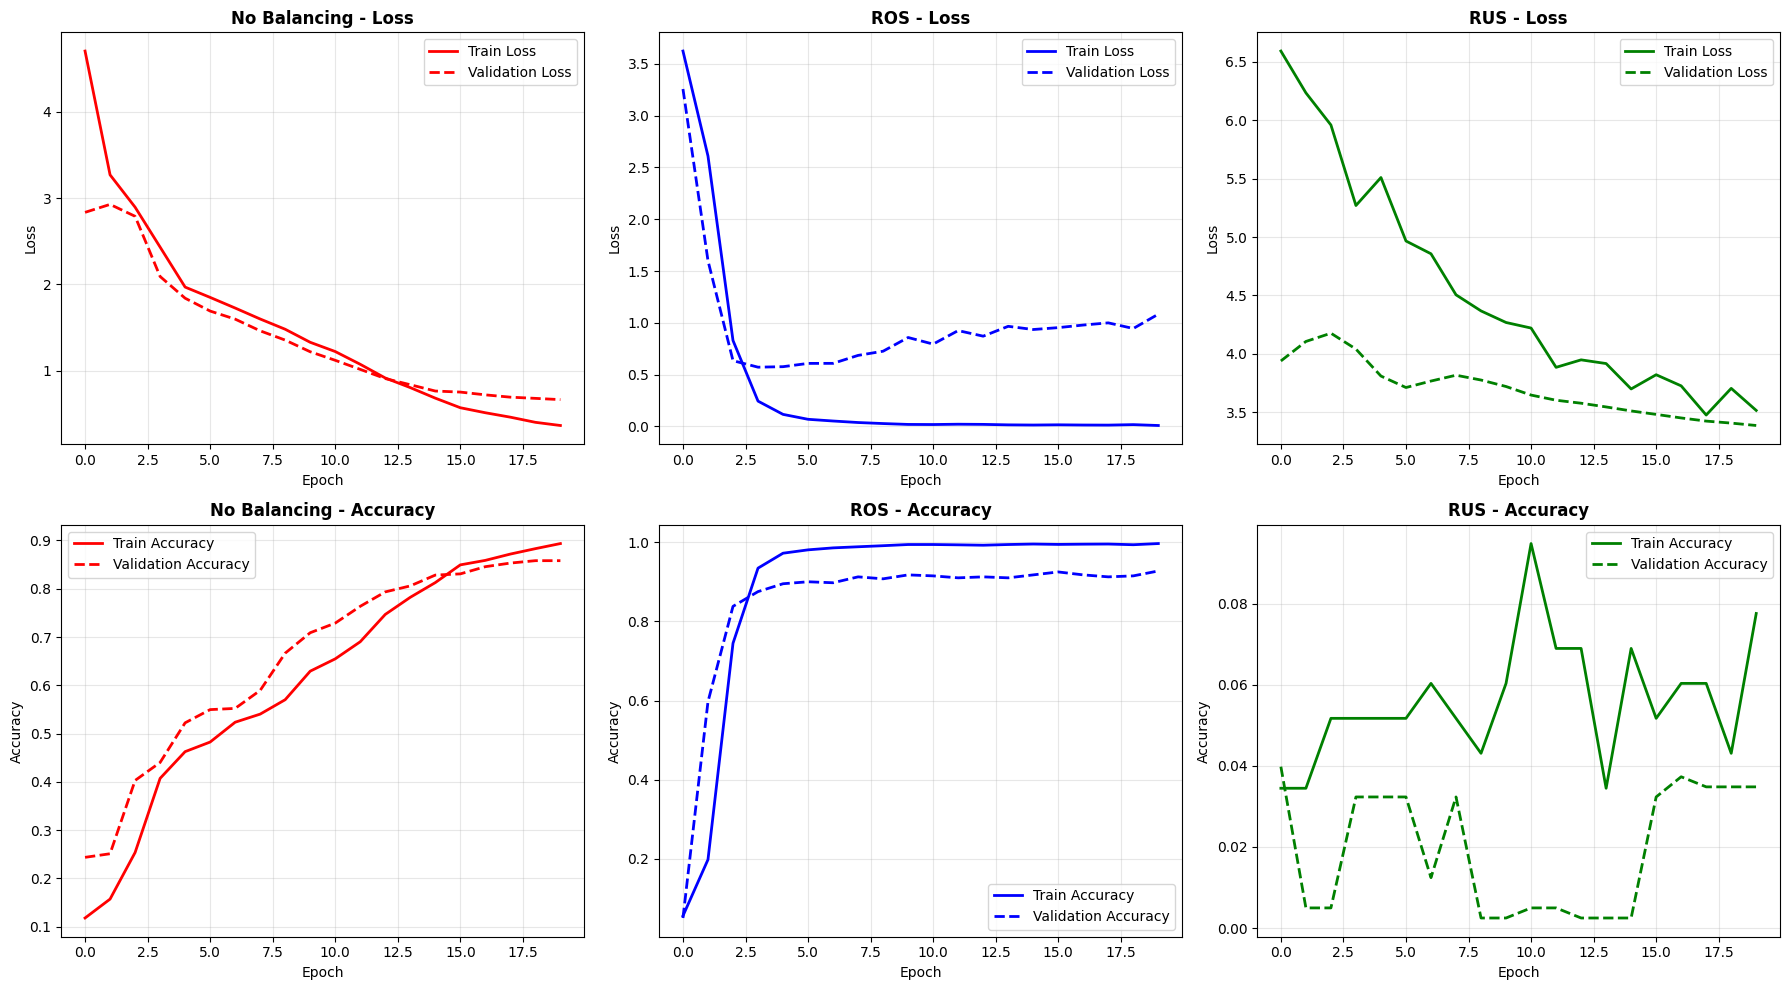

✓ Curves saved in: models/curvas_aprendizaje_comparacion.png


In [197]:
# Learning curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss curves
histories = [
    (resultados_original['history'], 'No Balancing', 'red'),
    (resultados_ros['history'], 'ROS', 'blue'),
    (resultados_rus['history'], 'RUS', 'green')
]

for idx, (history, nombre, color) in enumerate(histories):
    # Training Loss
    axes[0, idx].plot(history.history['loss'], label='Train Loss', color=color, linewidth=2)
    axes[0, idx].plot(history.history['val_loss'], label='Validation Loss', color=color, linestyle='--', linewidth=2)
    axes[0, idx].set_title(f'{nombre} - Loss', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)

    # Training Accuracy
    axes[1, idx].plot(history.history['acc'], label='Train Accuracy', color=color, linewidth=2)
    axes[1, idx].plot(history.history['val_acc'], label='Validation Accuracy', color=color, linestyle='--', linewidth=2)
    axes[1, idx].set_title(f'{nombre} - Accuracy', fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Accuracy')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/curvas_aprendizaje_comparacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Curves saved in: models/curvas_aprendizaje_comparacion.png")

### 21.7 Comparación de matrices de confusión

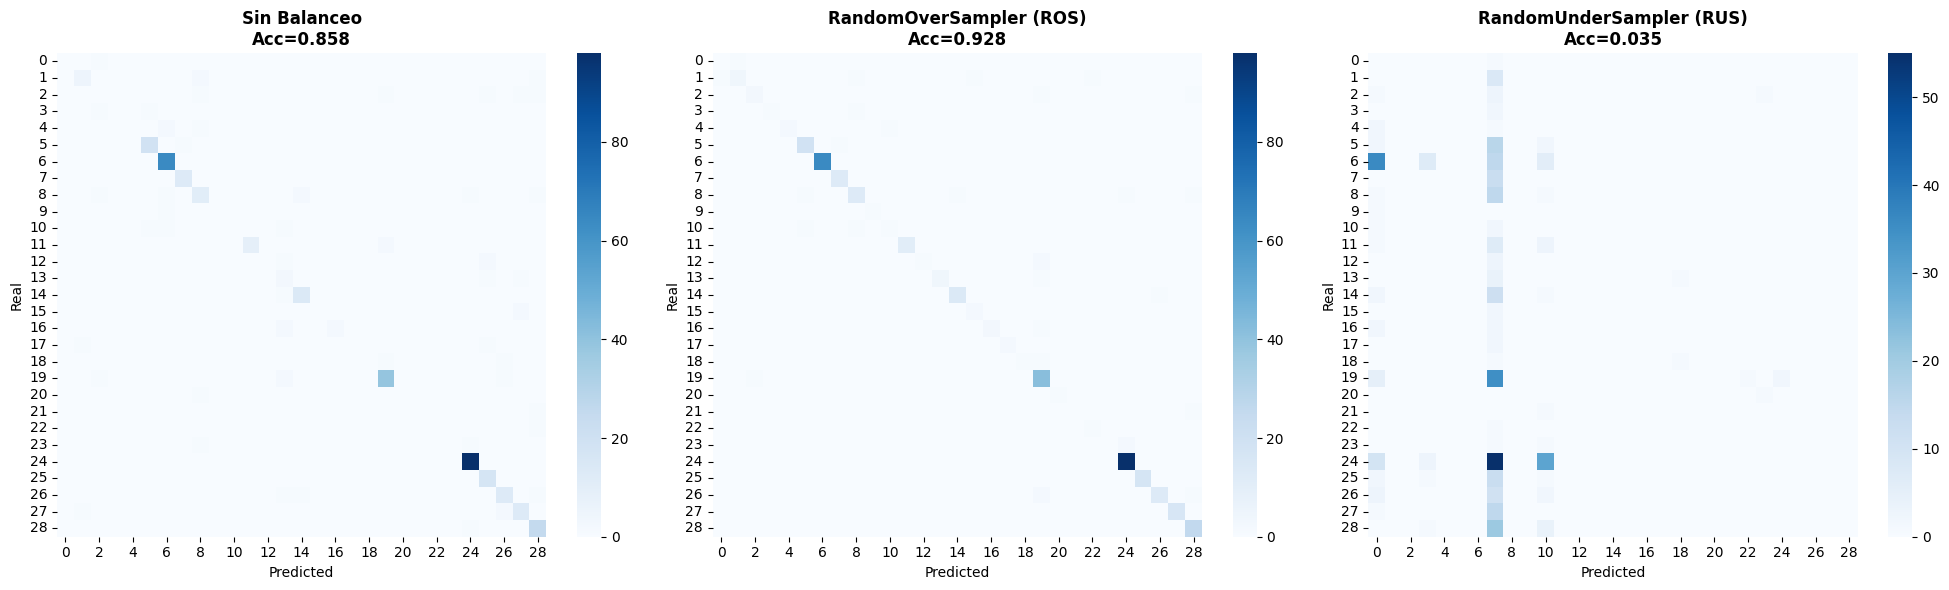

✓ Matrices guardadas en: models/confusion_matrices_comparacion.png


In [198]:
# Visualizar matrices de confusión lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

cms = [
    (resultados_original['cm'], 'Sin Balanceo'),
    (resultados_ros['cm'], 'RandomOverSampler (ROS)'),
    (resultados_rus['cm'], 'RandomUnderSampler (RUS)')
]


for idx, (cm_data, nombre) in enumerate(cms):
    sns.heatmap(cm_data, annot=False, cmap='Blues', cbar=True, fmt='d', ax=axes[idx])
    axes[idx].set_title(f'{nombre}\nAcc={comparacion_df.iloc[idx]["Accuracy"]:.3f}',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Real')

plt.tight_layout()
plt.savefig('models/confusion_matrices_comparacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Matrices guardadas en: models/confusion_matrices_comparacion.png")

### Comparison of errors between balancing strategies

  Estrategia  Total_Errores  Total_Predicciones  Tasa_Error_%  Accuracy_%
No Balancing             57                 402         14.18       85.82
         ROS             29                 402          7.21       92.79
         RUS            388                 402         96.52        3.48


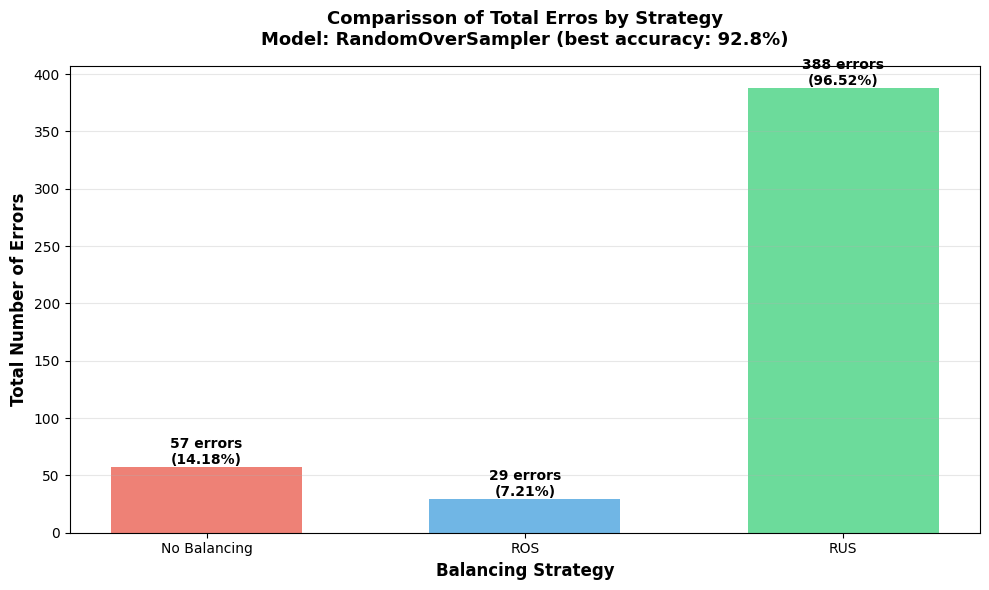


✓ Gráfico guardado en: models/comparacion_total_errores.png


In [199]:
# Comparación de errores entre las tres estrategias
print("### Comparison of errors between balancing strategies\n")

estrategias = [
    (resultados_original['cm'], 'No Balancing'),
    (resultados_ros['cm'], 'ROS'),
    (resultados_rus['cm'], 'RUS')
]

comparacion_errores = []
for cm, nombre in estrategias:
    total_errores = np.sum(cm) - np.trace(cm)  # Total - diagonal
    total_predicciones = np.sum(cm)
    tasa_error = (total_errores / total_predicciones) * 100

    comparacion_errores.append({
        'Estrategia': nombre,
        'Total_Errores': int(total_errores),
        'Total_Predicciones': int(total_predicciones),
        'Tasa_Error_%': round(tasa_error, 2),
        'Accuracy_%': round((1 - tasa_error/100) * 100, 2)
    })

comparacion_df = pd.DataFrame(comparacion_errores)
print(comparacion_df.to_string(index=False))

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparacion_df))
width = 0.6

bars = ax.bar(x, comparacion_df['Total_Errores'], width,
              color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.7)

# Añadir valores sobre las barras
for i, (bar, row) in enumerate(zip(bars, comparacion_df.iterrows())):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f"{int(height)} errors\n({row[1]['Tasa_Error_%']}%)",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Balancing Strategy', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Number of Errors', fontsize=12, fontweight='bold')
ax.set_title('Comparisson of Total Erros by Strategy\n' +
             f'Model: RandomOverSampler (best accuracy: {resultados_ros["metrics"]["accuracy"]:.1%})',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(comparacion_df['Estrategia'])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('models/comparacion_total_errores.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico guardado en: models/comparacion_total_errores.png")


### 21.8 Análisis por clase: Recall comparison


📊 Recall by class (Top 15 most frequent classes):
 GRD  No Balancing      ROS  RUS  Support
7114      1.000000 1.000000  0.0       98
6113      1.000000 1.000000  0.0       64
6418      0.906977 0.976744  0.0       43
7414      0.961538 1.000000  0.0       26
6112      0.950000 0.950000  0.0       20
7410      1.000000 1.000000  0.0       17
6120      0.647059 0.764706  0.0       17
7413      0.812500 1.000000  0.0       16
7412      0.812500 0.812500  0.0       16
6413      0.933333 0.933333  0.0       15
6114      1.000000 1.000000  1.0       13
6150      0.818182 1.000000  0.0       11
4102      0.625000 0.500000  0.0        8
6412      0.600000 0.800000  0.0        5
4120      0.000000 0.600000  0.0        5


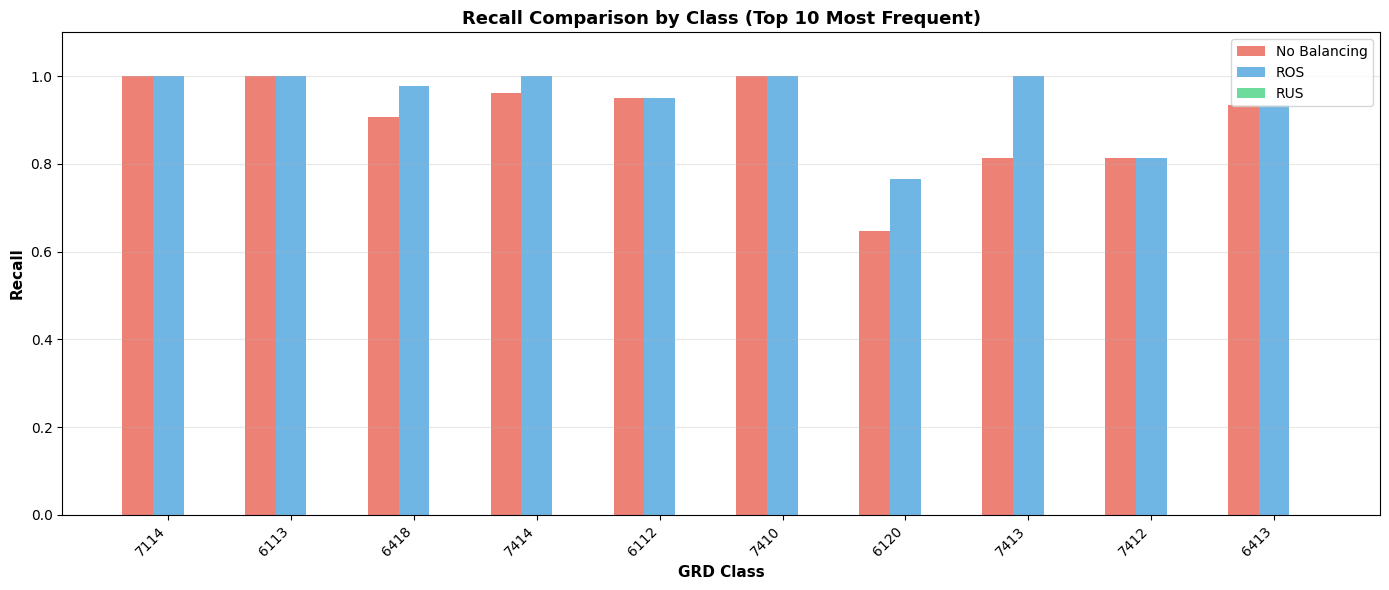


✓ Graph saved in: models/recall_por_clase_comparacion.png


In [200]:
# Calculate recall per class for each strategy
from sklearn.metrics import recall_score

y_true = np.argmax(y_test, axis=1)

recall_original = recall_score(y_true, resultados_original['predictions']['y_pred'],
                                average=None, zero_division=0)
recall_ros = recall_score(y_true, resultados_ros['predictions']['y_pred'],
                          average=None, zero_division=0)
recall_rus = recall_score(y_true, resultados_rus['predictions']['y_pred'],
                          average=None, zero_division=0)

# Create DataFrame for comparison
recall_comparison = pd.DataFrame({
    'GRD': grd_labels,
    'No Balancing': recall_original, # Translated label
    'ROS': recall_ros,
    'RUS': recall_rus,
    'Support': pd.Series(y_true).value_counts().sort_index().values
})

# Order by support (classes with more examples first)
recall_comparison = recall_comparison.sort_values('Support', ascending=False)

print("\n📊 Recall by class (Top 15 most frequent classes):") # Translated print statement
print(recall_comparison.head(15).to_string(index=False))

# Visualize recall by class for top 10
top_10_classes = recall_comparison.head(10)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(top_10_classes))
width = 0.25

bars1 = ax.bar(x - width, top_10_classes['No Balancing'], width, label='No Balancing',
               color='#e74c3c', alpha=0.7)
bars2 = ax.bar(x, top_10_classes['ROS'], width, label='ROS',
               color='#3498db', alpha=0.7)
bars3 = ax.bar(x + width, top_10_classes['RUS'], width, label='RUS',
               color='#2ecc71', alpha=0.7)

ax.set_xlabel('GRD Class', fontsize=11, fontweight='bold')
ax.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax.set_title('Recall Comparison by Class (Top 10 Most Frequent)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_10_classes['GRD'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('models/recall_por_clase_comparacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Graph saved in: models/recall_por_clase_comparacion.png")

### 23 Tabla comparativa de errores de clasificación

In [201]:
# Create mapping of indices to GRD information
# Important: some GRD_final have multiple codes/descriptions
# We group and concatenate them to show all variants
grd_info_grouped = encoded_df_filter_final.groupby('GRD_final').agg({
    'GRD_codigo': lambda x: x.dropna().drop_duplicates().tolist(),
    'GRD_descripcion': lambda x: x.dropna().drop_duplicates().tolist()
}).reset_index()

# Function to get GRD information
def get_grd_info(grd_idx):
    """
    Returns code and description for a GRD index.
    If there are multiple values, they are concatenated.
    """
    grd_code = grd_labels[grd_idx]
    row = grd_info_grouped[grd_info_grouped['GRD_final'] == grd_code]

    if len(row) == 0:
        return grd_code, grd_code, "Description not available"

    codigos = row.iloc[0]['GRD_codigo']
    descripciones = row.iloc[0]['GRD_descripcion']

    # Take first code/description for simplicity
    codigo = codigos[0] if isinstance(codigos, list) and len(codigos) > 0 else codigos
    descripcion = descripciones[0] if isinstance(descripciones, list) and len(descripciones) > 0 else descripciones

    return grd_code, codigo, descripcion

print(f"✓ Mapping created for {len(grd_labels)} GRD classes")
print(f"✓ Total unique GRDs in mapping: {len(grd_info_grouped)}")

✓ Mapping created for 29 GRD classes
✓ Total unique GRDs in mapping: 29


In [202]:
# Create GRD to FONASA 2016 price mapping
grd_precios = encoded_df_filter_final.groupby('GRD_final')['Precio FONASA 2016'].first().to_dict()

print(f"✓ Prices available for {len(grd_precios)} GRDs")

# Create comparative error table for the ROS model (best performance)
cm_ros = resultados_ros['cm']
errores_data = []

# Iterate through confusion matrix and extract errors (off-diagonal elements)
for i in range(len(grd_labels)):
    for j in range(len(grd_labels)):
        if i != j and cm_ros[i, j] > 0:  # Only errors (non-diagonal) with count > 0
            grd_real_idx, codigo_real, desc_real = get_grd_info(i)
            grd_pred_idx, codigo_pred, desc_pred = get_grd_info(j)

            # Get prices
            precio_real = grd_precios.get(grd_real_idx, 0)
            precio_pred = grd_precios.get(grd_pred_idx, 0)
            diferencia_precio = precio_real - precio_pred

            errores_data.append({
                'True_GRD': grd_real_idx, # Translated label
                'True_Code': codigo_real, # Translated label
                'True_Description': desc_real, # Translated label
                'Predicted_GRD': grd_pred_idx, # Translated label
                'Predicted_Code': codigo_pred, # Translated label
                'Predicted_Description': desc_pred, # Translated label
                'Num_Errors': int(cm_ros[i, j]), # Translated label
                'FONASA_Real_Price': precio_real, # Translated label
                'FONASA_Pred_Price': precio_pred, # Translated label
                'Price_Difference': diferencia_precio, # Translated label
                'Total_Loss': diferencia_precio * cm_ros[i, j] # Translated label
            })

# Create DataFrame and sort by absolute total loss
errores_df = pd.DataFrame(errores_data)
errores_df['Abs_Loss'] = errores_df['Total_Loss'].abs() # Translated label
errores_df = errores_df.sort_values('Abs_Loss', ascending=False)

# Save complete table
errores_df.to_csv('models/tabla_errores_clasificacion.csv', index=False)

print(f"\n✓ Total pairs with errors: {len(errores_df)}") # Translated print statement
print(f"✓ Total errors: {errores_df['Num_Errors'].sum()}") # Translated print statement
print(f"\n💰 Economic Impact:") # Translated print statement
print(f"  Total loss: ${errores_df['Total_Loss'].sum():,.0f}") # Translated print statement
print(f"  Average loss per error: ${errores_df['Total_Loss'].mean():,.0f}") # Translated print statement
print(f"\n📊 Top 15 errors with highest economic impact:\n") # Translated print statement
print(errores_df[['True_GRD', 'Predicted_GRD', 'Num_Errors', 'FONASA_Real_Price',
                   'FONASA_Pred_Price', 'Price_Difference', 'Total_Loss']].head(15).to_string(index=False))
print(f"\n✓ Complete table saved to: models/tabla_errores_clasificacion.csv") # Translated print statement

✓ Prices available for 29 GRDs

✓ Total pairs with errors: 26
✓ Total errors: 29

💰 Economic Impact:
  Total loss: $25,028,942
  Average loss per error: $962,652

📊 Top 15 errors with highest economic impact:

 True_GRD  Predicted_GRD  Num_Errors  FONASA_Real_Price  FONASA_Pred_Price  Price_Difference    Total_Loss
     4101           4102           1       1.893578e+07       9.416848e+06      9.518933e+06  9.518933e+06
     4102           4101           1       9.416848e+06       1.893578e+07     -9.518933e+06 -9.518933e+06
     4102           6414           1       9.416848e+06       1.768050e+06      7.648798e+06  7.648798e+06
     4102           6120           1       9.416848e+06       2.020658e+06      7.396190e+06  7.396190e+06
     4102           7112           1       9.416848e+06       2.331441e+06      7.085407e+06  7.085407e+06
     7113           7114           2       2.605500e+06       1.417049e+06      1.188451e+06  2.376902e+06
     6112           6114           1     

In [203]:
errores_df

,True_GRD,True_Code,True_Description,Predicted_GRD,Predicted_Code,Predicted_Description,Num_Errors,FONASA_Real_Price,FONASA_Pred_Price,Price_Difference,Total_Loss,Abs_Loss
0,4101,41013,PH ECMO VENTILACIÓN MECÁNICA PROLONGADA CON TR...,4102,41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,1,1.893578e+07,9.416848e+06,9.518933e+06,9.518933e+06,9.518933e+06
1,4102,41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,4101,41013,PH ECMO VENTILACIÓN MECÁNICA PROLONGADA CON TR...,1,9.416848e+06,1.893578e+07,-9.518933e+06,-9.518933e+06,9.518933e+06
3,4102,41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,6414,64143,MH INSUFICIENCIA VASCULAR GASTROINTESTINAL W/MCC,1,9.416848e+06,1.768050e+06,7.648798e+06,7.648798e+06,7.648798e+06
2,4102,41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,6120,61201,PH PROCEDIMIENTOS COMPLEJOS DEL TRACTO DIGESTIVO,1,9.416848e+06,2.020658e+06,7.396190e+06,7.396190e+06,7.396190e+06
4,4102,41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,7112,71122,PH COLECISTECTOMÍA EXCEPTO LAPAROSCÓPICA W/CC,1,9.416848e+06,2.331441e+06,7.085407e+06,7.085407e+06,7.085407e+06
23,7113,71133,PH OTROS PROCEDIMIENTOS HEPATOBILIARES Y SOBRE...,7114,71141,PH COLECISTECTOMÍA LAPAROSCÓPICA,2,2.605500e+06,1.417049e+06,1.188451e+06,2.376902e+06,2.376902e+06
9,6112,61123,PH PROCEDIMIENTOS SOBRE HERNIA EXCEPTO INGUINA...,6114,61141,PH PROCEDIMIENTOS SOBRE HERNIA INGUINAL Y FEMORAL,1,2.755148e+06,1.093000e+06,1.662149e+06,1.662149e+06,1.662149e+06
16,6411,64111,MH GASTRITIS Y ÚLCERA PÉPTICA,6418,64183,MH OTROS DIAGNÓSTICOS SOBRE APARATO DIGESTIVO ...,2,8.452500e+05,1.644300e+06,-7.990500e+05,-1.598100e+06,1.598100e+06
22,7111,71111,PH PROCEDIMIENTOS COMPLEJOS SOBRE SISTEMA BILIAR,7414,74141,MH OTRAS ENFERMEDADES DEL SISTEMA BILIAR,1,2.217547e+06,8.698500e+05,1.347697e+06,1.347697e+06,1.347697e+06
14,6140,61401,PH OTROS PROCEDIMIENTOS SOBRE APARATO DIGESTIVO,6112,61123,PH PROCEDIMIENTOS SOBRE HERNIA EXCEPTO INGUINA...,1,1.554887e+06,2.755148e+06,-1.200261e+06,-1.200261e+06,1.200261e+06


### 24 Conclusiones: ROS vs RUS

**Análisis de resultados:**

1. **Accuracy General:**
   - Métrica global que puede ser engañosa en datasets desbalanceados
   - Favorece clases mayoritarias en modelo sin balanceo

2. **Precision, Recall y F1 (macro):**
   - Promedian métricas de todas las clases por igual
   - Mejor indicador de rendimiento balanceado entre clases

3. **Trade-offs observados:**

   **RandomOverSampler (ROS):**
   - ✅ Mantiene toda la información original
   - ✅ Mejor para clases minoritarias
   - ⚠️ Mayor tiempo de entrenamiento (más datos)
   - ⚠️ Riesgo de overfitting (duplica ejemplos)
   
   **RandomUnderSampler (RUS):**
   - ✅ Entrenamiento más rápido (menos datos)
   - ✅ Menor riesgo de overfitting
   - ⚠️ Pierde información de clases mayoritarias
   - ⚠️ Puede subajustar en clases con pocos ejemplos
   
   **Sin Balanceo (Baseline):**
   - ✅ Representa distribución real de datos
   - ✅ No introduce sesgo artificial
   - ⚠️ Sesgo hacia clases mayoritarias
   - ⚠️ Pobre recall en clases minoritarias

4. **Recomendación:**
   - Si **tiempo** es limitado → RUS
   - Si **recall en minoritarias** es crítico → ROS
   - Si distribución real importa → Sin balanceo + class_weight
   - En general: **ROS tiende a mejor F1 macro** para problemas multiclase desbalanceados